# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [2]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 80.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.19.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [2]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [4]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

# Loading image file of dataset
images=np.load('/content/drive/MyDrive/AIML/M6_CV/Project/images_proj.npy')

# Loading the labels file of the dataset
labels=pd.read_csv('/content/drive/MyDrive/AIML/M6_CV/Project/Labels_proj.csv')

In [6]:
# Checking shape of the data
print(images.shape)
print(labels.shape)

(631, 200, 200, 3)
(631, 1)


* There are 631 RGB images of shape 200x200, each having 3 channels.

# **Exploratory Data Analysis**

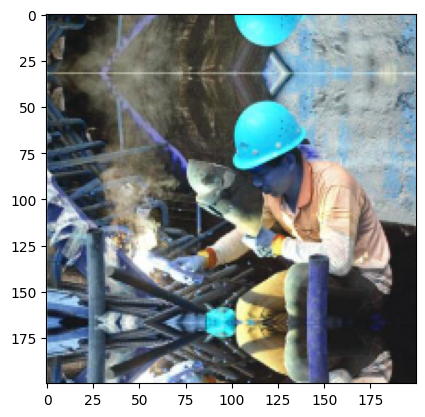

In [7]:
# Visualizing an image
plt.imshow(images[1]);

* The coloring of the image does not look right. This is becuase images in OpenCV return BGR, but matplotlib expects RGB, therefore we need to convert the images to RGB.

In [8]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

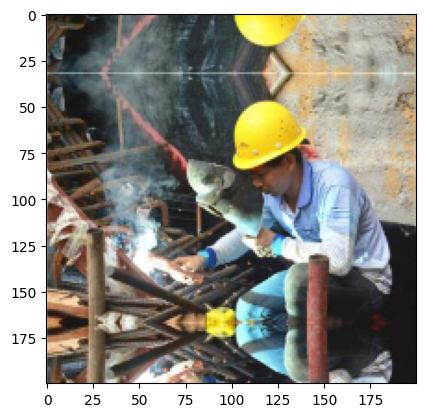

In [9]:
# Checking the same image after BGR to RGB conversion
plt.imshow(images[1]);

* Now the image appears normal.

###Plot random images from each of the classes and print their corresponding labels.

In [10]:
# Defining function to plot random images of each class
def plot_images(images,labels):
  num_classes=2
  categories=np.unique(labels)
  keys=dict(labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(10, 8))
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[random_index, :])
          ax.set_title(keys[random_index])
  plt.show()

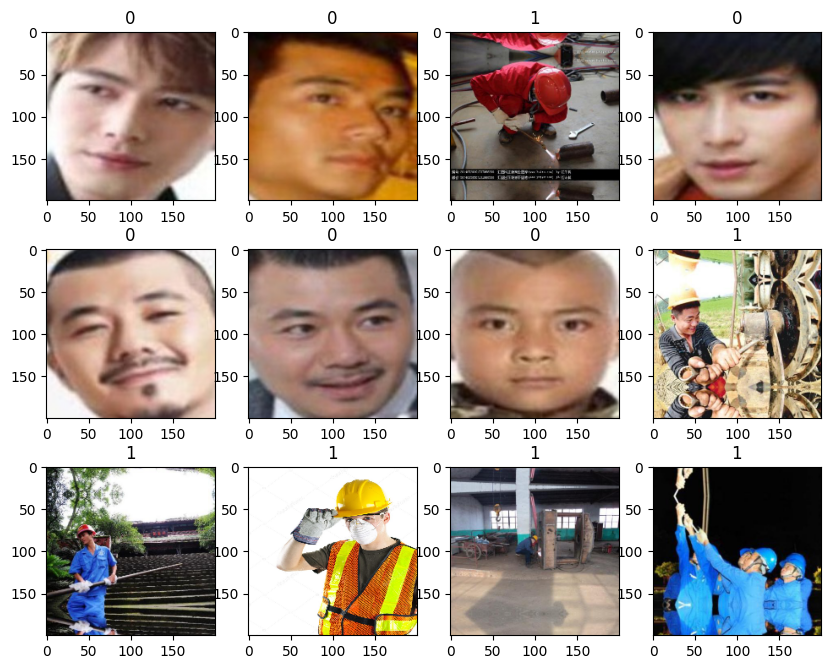

In [11]:
plot_images(images,labels)

* As you can see, images with the label '0' are close-up photos of individuals without a helmet and images with the label '1' are photos of individuals with a helmet in different background and contexts.
  * The images with a helmet appear to have been augmented to some extent already.

## Checking for class imbalance


In [12]:
# Checking proportion of label class
labels.value_counts()

,count
Label,
0,320
1,311


* Observations:
  * There is no class imbalance of the labels.
    * There are 320 images without a helmet.
    * There are 311 images with a helmet.
  * However there appears to be **dataset bias**
    * Images without a helmet are close-ups where the face dominates the frame. Whereas the images without a helmet, the worker is often small in the scene with lots of background.
      * The model might learn to distinguish based on scale and context, not on the helmet itself.
      * This could lead to poor generalization of the model with external data. For example: if a no-helmet worker is in a distant shot, it may wrongly predict "With Helmet" due to the context.
      * Data augmentation can be utilized to help mitigate this bias.

# **Data Preprocessing**

In [13]:
# Function to plot the original and grayscale images side by side
def grid_plot(img1,img2,gray=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img1)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    if gray:
      axes[1].imshow(img2,cmap='gray')
    else:
      axes[1].imshow(img2)
    axes[1].set_title('Grayscale Image')
    axes[1].axis('off')

    plt.show()

## Converting images to grayscale

In [14]:
# Converting images to grayscale
gray_images = []
for i in range(len(images)):
  gray_images.append(cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY))

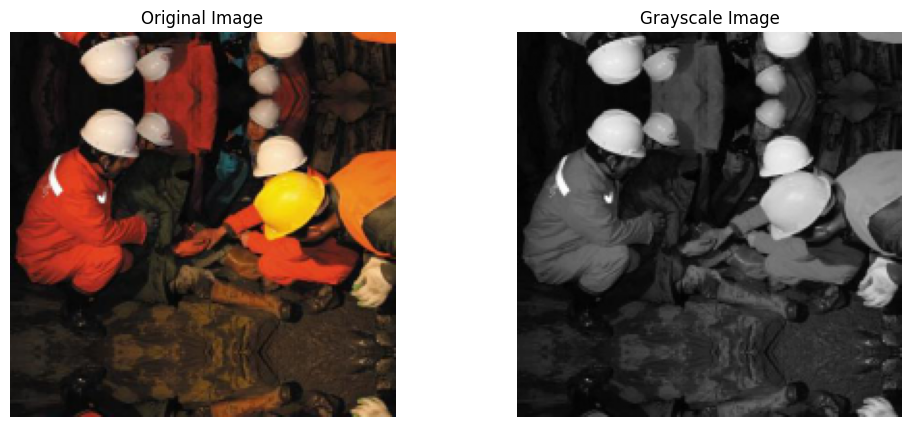

In [15]:
# Comparing RGB and Grayscale images
n = 4 # Change n to choose a different image to compare
grid_plot(images[n],gray_images[n],gray=True)

### Splitting the dataset



In [16]:
# Splitting the grayscale dataset (for simple CNN model)
X_train_gray, X_temp_gray, y_train_gray, y_temp_gray = train_test_split(np.array(gray_images),labels , test_size=0.2, random_state=42,stratify=labels)
X_val_gray, X_test_gray, y_val_gray, y_test_gray = train_test_split(X_temp_gray,y_temp_gray , test_size=0.5, random_state=42,stratify=y_temp_gray)

In [17]:
# Splitting the RGB dataset (for the VGG16-based models)
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images),labels , test_size=0.2, random_state=42,stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp)

* I am data splitting both the grayscale and RGB images
  * The grayscale images will be used for the simple CNN model.
  * The RGB images will be used for the VGG16-based models.
* I am splitting the data (for both grayscale and RGB) into 80% for training, 10% for validation and 10% for testing.

### Data Normalization

In [18]:
# Normalizing the grayscale image pixels
X_train_gray_normalized = X_train_gray.astype('float32')/255.0
X_val_gray_normalized = X_val_gray.astype('float32')/255.0
X_test_gray_normalized = X_test_gray.astype('float32')/255.0

In [19]:
# Normalizing the RGB image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

* Data normalization improves training speed and helps mitigate exploding or vanishing gradients.

# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [20]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [21]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

In [22]:
# Building a simple CNN
model1 = Sequential()
model1.add(Conv2D(64, (3,3), activation='relu', input_shape=(200, 200, 1), padding = 'same'))
model1.add(MaxPooling2D(2,2))
model1.add(BatchNormalization())
model1.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model1.add(MaxPooling2D(2,2))
model1.add(BatchNormalization())
model1.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [23]:
# Compiling the model
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])

In [24]:
# Model summary
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 676,593 (2.58 MB)

 Trainable params: 676,401 (2.58 MB)

 Non-trainable params: 192 (768.00 B)

* Model 1 architecture
  * Feature extraction component:
    * 4 convolution layers
    * 3 pooling layers
  * Prediction component:
    * Flatten layer
      * To convert output feature map into a 1D array to be fed into the feed forward nueral network
    * 4 dense layers
  * Configuration:
    * Loss function: Binary crossentropy
    * Optimizer: Adam
    * Epochs: 15
    * Batch size=32
  * Batch normalization and dropout is utilized to prevent overfitting.
  * 676,593 total parameters of which 676,401 are trainable.

In [31]:
# Training the model
history_1 = model1.fit(
            X_train_gray_normalized, y_train_gray,
            epochs=15,
            validation_data=(X_val_gray_normalized, y_val_gray),
            shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/15
16/16 - 1s - 62ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.5238 - val_loss: 2.4572
Epoch 2/15
16/16 - 1s - 52ms/step - accuracy: 0.9980 - loss: 0.0057 - val_accuracy: 0.5397 - val_loss: 2.3683
Epoch 3/15
16/16 - 1s - 50ms/step - accuracy: 0.9960 - loss: 0.0203 - val_accuracy: 0.5714 - val_loss: 1.8275
Epoch 4/15
16/16 - 1s - 50ms/step - accuracy: 0.9940 - loss: 0.0100 - val_accuracy: 0.7778 - val_loss: 0.8099
Epoch 5/15
16/16 - 1s - 50ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9206 - val_loss: 0.2289
Epoch 6/15
16/16 - 1s - 50ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.7778 - val_loss: 0.7220
Epoch 7/15
16/16 - 1s - 50ms/step - accuracy: 0.9940 - loss: 0.0306 - val_accuracy: 0.8254 - val_loss: 0.6306
Epoch 8/15
16/16 - 1s - 50ms/step - accuracy: 0.9980 - loss: 0.0060 - val_accuracy: 0.9206 - val_loss: 0.2055
Epoch 9/15
16/16 - 1s - 50ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.5397 - val_loss: 3.3619
Epoch 10/1

### Vizualizing the predictions

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


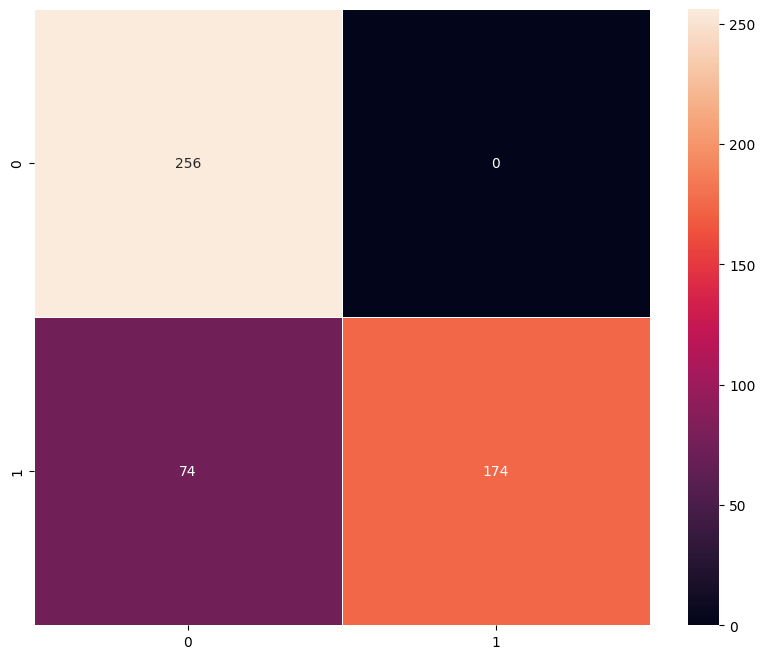

In [32]:
# Plotting confusion matrix of model 1 on train data
model1_train_conf_matrix=plot_confusion_matrix(model1,X_train_gray_normalized,y_train_gray)
model1_train_conf_matrix

In [33]:
# Performance metrics of model 1 on train data
model1_train_perf=model_performance_classification(model1,X_train_gray_normalized,y_train_gray)
model1_train_perf

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.853175,0.853175,0.886099,0.849572


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


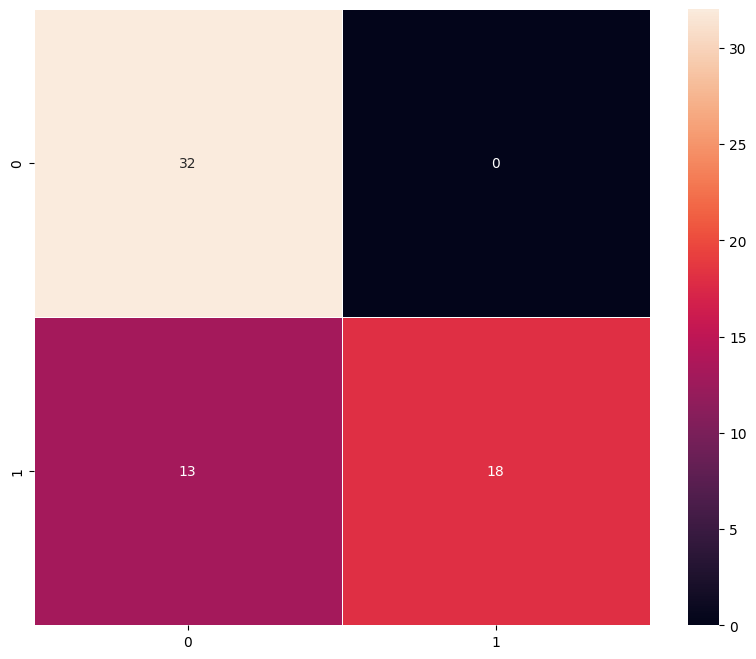

In [34]:
# Plotting confusion matrix of model 1 on validation data
model1_val_conf_matrix=plot_confusion_matrix(model1,X_val_gray_normalized,y_val_gray)
model1_val_conf_matrix

In [35]:
# Performance metrics of model 1 on validation data
model1_val_perf=model_performance_classification(model1,X_val_gray_normalized,y_val_gray)
model1_val_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.793651,0.793651,0.853263,0.783697


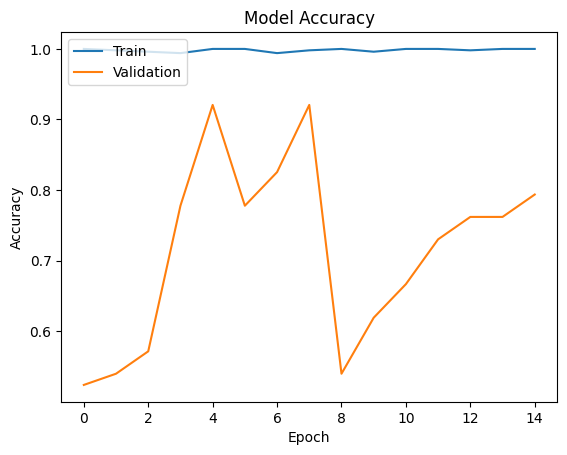

In [36]:
# Plotting train and validation accuracy over epochs
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Model 1 performance
  * Train set
    * Good performance with an accuracy around 85%
    * The model successfully detected all images without a helmet (256)
    * Out of 248 images with a helmet, the model only predicted 174 images with a helmet
  * Validation set
    * Good performance with around 80% accuracy
    * The model successfully detected all images without a helmet (32)
    * Out of 31 images with a helmet, the model only predicted 18 images with a helmet
  * Generalization
    * The model has good generalization ability since the validation metrics are similar to the train metrics. Therefore model has avoided overfitting.

## Model 2: (VGG-16 (Base))

In [38]:
# Clearing backend to avoid memory buildup
from tensorflow.keras import backend as K
K.clear_session()

In [39]:
# Loading base VGG16 model without the dense layers
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (200,200,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [40]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [41]:
model_2 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_2.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_2.add(Flatten())

# Adding a dense output layer
model_2.add(Dense(1, activation='sigmoid'))

In [43]:
# Compiling the model
model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])

In [44]:
# Model Summary
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

* Model 2 architecture
  * Feature extraction component (VGG16-base):
    * 13 convolution layers
    * 5 pooling layers
  * Prediction component:
    * Flatten layer
    * 1 dense output layer
  * Configuration:
    * Loss function: Binary crossentropy
    * Optimizer: Adam
    * Epochs: 15
    * Batch size=32
  * 14,733,121 total parameters of which only 18,433 are trainable. This difference is due to the frozen weights in the VGG16 convolution layers.

In [45]:
# Training the model
history_2 = model_2.fit(
            X_train_normalized, y_train,
            epochs=15,
            validation_data=(X_val_normalized, y_val),
            shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/15
16/16 - 43s - 3s/step - accuracy: 0.9008 - loss: 0.2182 - val_accuracy: 1.0000 - val_loss: 0.0227
Epoch 2/15
16/16 - 3s - 188ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 3/15
16/16 - 3s - 193ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 4/15
16/16 - 3s - 201ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 5/15
16/16 - 3s - 186ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 6/15
16/16 - 3s - 186ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 7/15
16/16 - 3s - 187ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 8/15
16/16 - 3s - 187ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 9/15
16/16 - 3s - 184ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0025
Epo

### Visualizing the prediction:

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step


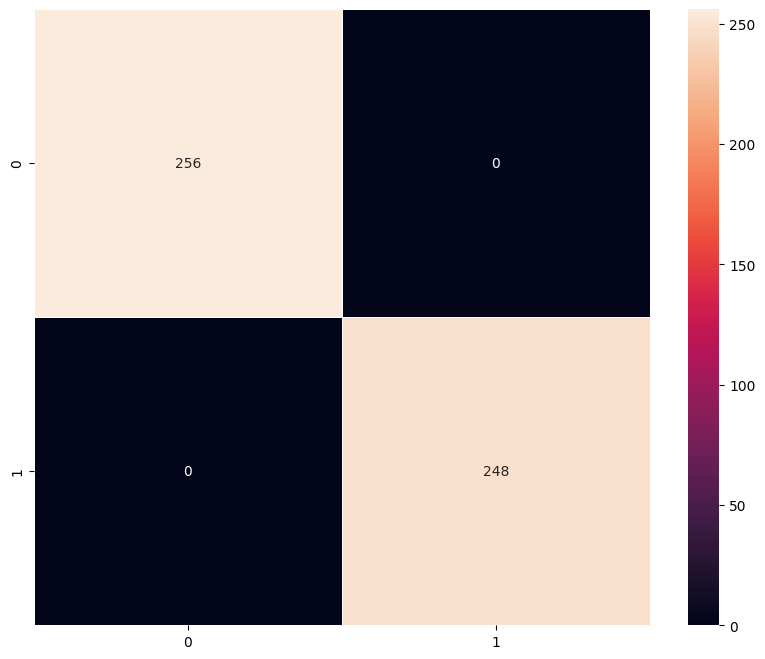

In [46]:
# Plotting confusion matrix of model 2 on train data
model2_train_conf_matrix=plot_confusion_matrix(model_2,X_train_normalized,y_train)
model2_train_conf_matrix

In [47]:
# Performance metrics of model 2 on train data
model2_train_perf=model_performance_classification(model_2,X_train_normalized,y_train)
model2_train_perf

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


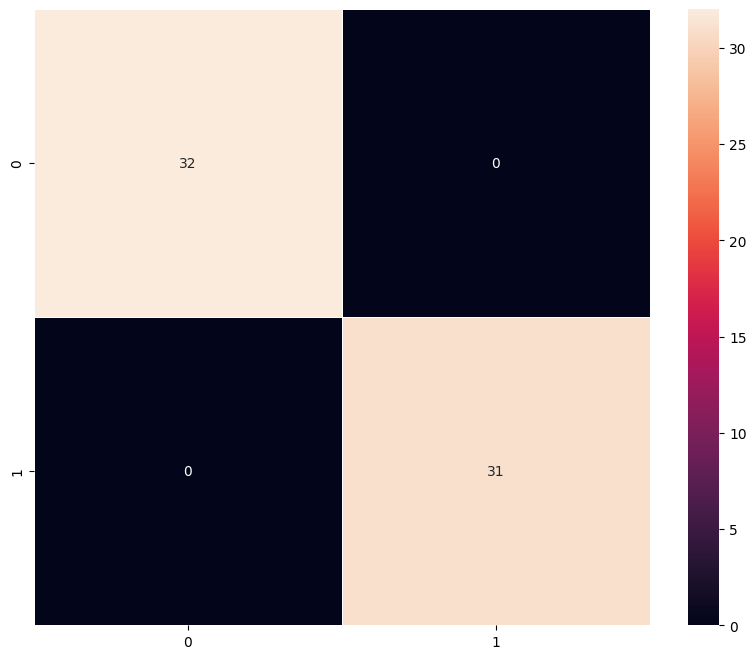

In [48]:
# Plotting confusion matrix of model 2 on validation data
model2_val_conf_matrix=plot_confusion_matrix(model_2,X_val_normalized,y_val)
model2_val_conf_matrix

In [49]:
# Performance metrics of model 2 on validation data
model2_val_perf=model_performance_classification(model_2,X_val_normalized,y_val)
model2_val_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


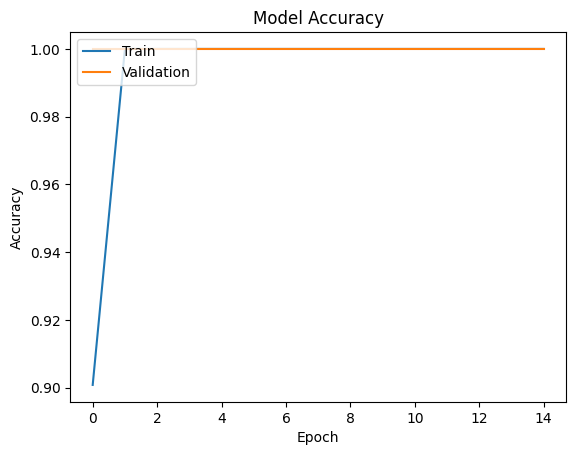

In [50]:
# Plotting train and validation accuracy over epochs
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Model 2 performance
  * Train set
    * Perfect performance with an accuracy of 100%
    * The model successfully detected all images without a helmet (256)
    * The model successfully detected all images with a helmet (248)
  * Validation set
    * Perfect performance with an accuracy of 100%
    * The model successfully detected all images without a helmet (32)
    * The model successfully detected all images with a helmet (31)
  * The model has perfect generalization ability (among unseen data within **this** dataset) since the validation and train metrics are both 100%

  * Important observation:
    * The surprisingly perfect performance on the train and validation dataset could be a result of the **dataset bias** that I mentioned earlier in the EDA.
    * Since images without a helmet are close-ups with the face dominating the frame and images with a helmet often have workers in a wide scene with differing backgrounds, the model **may not actually be learning helmet detection**. Instead, it's **learning image context** and **scale patterns**.
    * Due to VGG16's excellent feature extraction capabilities, it is easily picking up this dataset bias (even without the FFNN) and therefore making perfect predictions within this dataset.

## Model 3: (VGG-16 (Base + FFNN))

In [51]:
# Clearing backend to avoid memory buildup
K.clear_session()

In [61]:
model_3 = Sequential()

# Adding the convolutional part of the VGG16 model with frozen weights
model_3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_3.add(Flatten())

#Adding the Feed Forward neural network
model_3.add(Dense(64,activation='relu'))
model_3.add(Dropout(rate=0.2))
model_3.add(Dense(32,activation='relu'))

# Adding a dense output layer
model_3.add(Dense(1, activation='sigmoid'))

In [62]:
# Compiling the model
model_3.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])

In [63]:
# Model Summary
model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,896,513 (60.64 MB)

 Trainable params: 1,181,825 (4.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

* Model 3 architecture
  * Feature extraction component (VGG16-base):
    * 13 convolution layers
    * 5 pooling layers
  * Prediction component:
    * Flatten layer
    * 3 dense layers
    * Dropout is utilized to help prevent overfitting
  * Configuration:
    * Loss function: Binary crossentropy
    * Optimizer: Adam
    * Epochs: 15
    * Batch size=32
  * 15,896,513 total parameters of which only 1,181,825 are trainable. This difference is due to the frozen weights in the VGG16 convolution layers and. Only the weights within the FFNN are trainable parameters.

In [64]:
# Training the model
history_3 = model_3.fit(
            X_train_normalized, y_train,
            epochs=15,
            validation_data=(X_val_normalized, y_val),
            shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/15
16/16 - 9s - 548ms/step - accuracy: 0.9583 - loss: 0.0906 - val_accuracy: 1.0000 - val_loss: 2.1291e-04
Epoch 2/15
16/16 - 3s - 194ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 7.8025e-06
Epoch 3/15
16/16 - 3s - 195ms/step - accuracy: 1.0000 - loss: 8.3219e-04 - val_accuracy: 1.0000 - val_loss: 6.5401e-06
Epoch 4/15
16/16 - 3s - 199ms/step - accuracy: 1.0000 - loss: 1.2114e-04 - val_accuracy: 1.0000 - val_loss: 1.0375e-05
Epoch 5/15
16/16 - 3s - 201ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 8.6953e-07
Epoch 6/15
16/16 - 3s - 204ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 2.9305e-06
Epoch 7/15
16/16 - 3s - 203ms/step - accuracy: 1.0000 - loss: 6.2221e-04 - val_accuracy: 1.0000 - val_loss: 1.6363e-05
Epoch 8/15
16/16 - 3s - 201ms/step - accuracy: 1.0000 - loss: 8.8352e-05 - val_accuracy: 1.0000 - val_loss: 3.4909e-06
Epoch 9/15
16/16 - 3s - 200ms/step - accuracy: 1.0000 - loss: 2.

#### Visualizing the predictions

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step


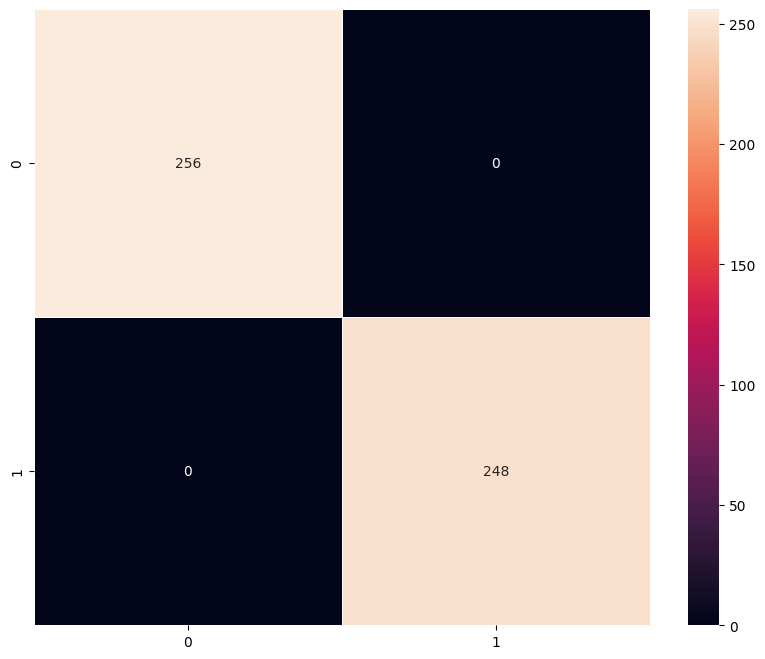

In [65]:
# Plotting confusion matrix of model 3 on train data
model3_train_conf_matrix=plot_confusion_matrix(model_3,X_train_normalized,y_train)
model3_train_conf_matrix

In [66]:
# Performance metrics of model 3 on train data
model3_train_perf=model_performance_classification(model_3,X_train_normalized,y_train)
model3_train_perf

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


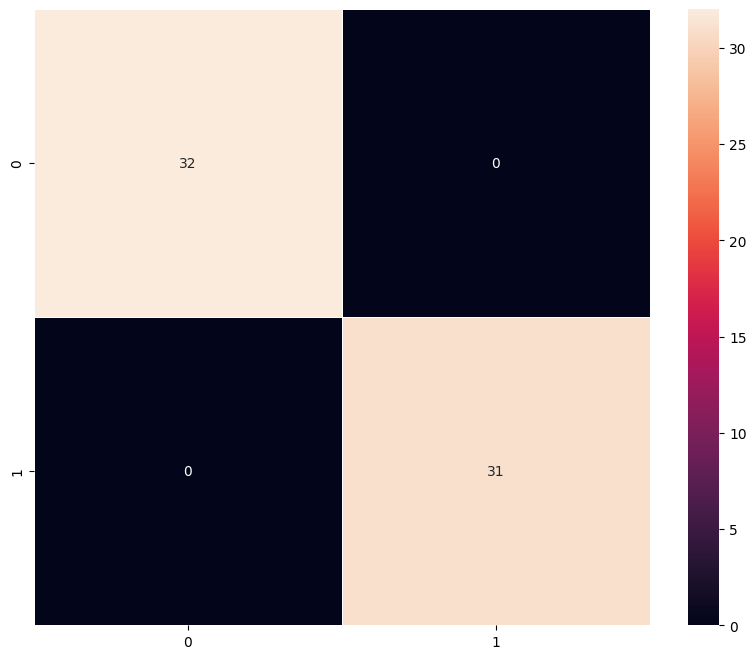

In [67]:
# Plotting confusion matrix of model 3 on validation data
model3_val_conf_matrix=plot_confusion_matrix(model_3,X_val_normalized,y_val)
model3_val_conf_matrix

In [68]:
# Performance metrics of model 3 on validation data
model3_val_perf=model_performance_classification(model_3,X_val_normalized,y_val)
model3_val_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


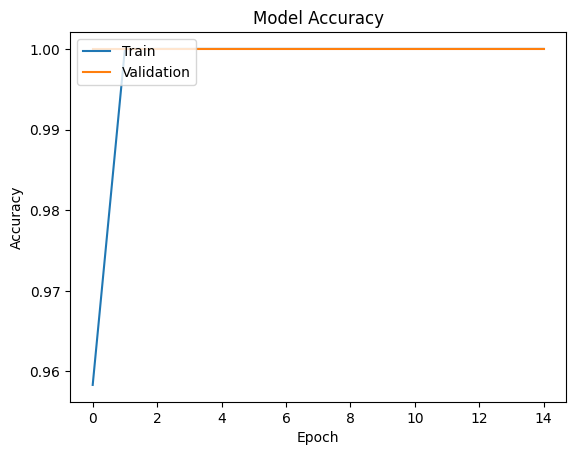

In [69]:
# Plotting train and validation accuracy over epochs
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Model 3 performance
  * Train set
    * Perfect performance with an accuracy of 100%
    * The model successfully detected all images without a helmet (256)
    * The model successfully detected all images with a helmet (248)
  * Validation set
    * Perfect performance with an accuracy of 100%
    * The model successfully detected all images without a helmet (32)
    * The model successfully detected all images with a helmet (31)
  * The model has perfect generalization ability (among unseen data within **this** dataset) since the validation and train metrics are both 100%

  * Important observation:
    * Just like in model 2, the perfect performance on the train and validation dataset could be a result of the **dataset bias** that I mentioned earlier in the EDA.
    * Since images without a helmet are close-ups with the face dominating the frame and images with a helmet often have workers in a wide scene with differing backgrounds, the model **may not actually be learning helmet detection**. Instead, it's **learning image context** and **scale patterns**.
    * Due to VGG16's excellent feature extraction capabilities, it is easily picking up this dataset bias (especially with the FFNN further reinforcing this bias) and therefore making perfect predictions within this dataset.

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [70]:
# Clearing backend to avoid memory buildup
K.clear_session()

In [71]:
model_4 = Sequential()

# Adding the convolutional part of the VGG16 model with frozen weights
model_4.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_4.add(Flatten())

#Adding the Feed Forward neural network
model_4.add(Dense(64,activation='relu'))
model_4.add(Dropout(rate=0.2))
model_4.add(Dense(32,activation='relu'))

# Adding a dense output layer
model_4.add(Dense(1, activation='sigmoid'))

In [72]:
# Compiling the model
model_4.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])

In [73]:
# Model Summary
model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,896,513 (60.64 MB)

 Trainable params: 1,181,825 (4.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

* Model 4 architecture (same as Model 3)
  * Feature extraction component (VGG16-base):
    * 13 convolution layers
    * 5 pooling layers
  * Prediction component:
    * Flatten layer
    * 3 dense layers
    * Dropout is utilized to help prevent overfitting
  * Configuration:
    * Loss function: Binary crossentropy
    * Optimizer: Adam
    * Epochs: 15
    * Batch size=32
  * 15,896,513 total parameters of which only 1,181,825 are trainable. This difference is due to the frozen weights in the VGG16 convolution layers and. Only the weights within the FFNN are trainable parameters.

In [74]:
# Applying data augmentation
train_datagen = ImageDataGenerator(
                              horizontal_flip=True,
                              vertical_flip=True,
                              rotation_range=20,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.3,
                              zoom_range=0.4
                              )

In [75]:
# Training the model using data augmentation
history_4 = model_4.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=32,
                                       seed=42,
                                       shuffle=True),
                    epochs=15,
                    validation_data=(X_val_normalized,y_val),
                    verbose=2)

Epoch 1/15
16/16 - 12s - 726ms/step - accuracy: 0.8988 - loss: 0.1795 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 2/15
16/16 - 5s - 317ms/step - accuracy: 0.9901 - loss: 0.0561 - val_accuracy: 1.0000 - val_loss: 4.7547e-04
Epoch 3/15
16/16 - 6s - 384ms/step - accuracy: 0.9841 - loss: 0.0309 - val_accuracy: 1.0000 - val_loss: 2.4339e-04
Epoch 4/15
16/16 - 5s - 319ms/step - accuracy: 0.9921 - loss: 0.0256 - val_accuracy: 1.0000 - val_loss: 1.1249e-04
Epoch 5/15
16/16 - 6s - 393ms/step - accuracy: 0.9940 - loss: 0.0235 - val_accuracy: 1.0000 - val_loss: 3.3315e-05
Epoch 6/15
16/16 - 5s - 318ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 2.9397e-06
Epoch 7/15
16/16 - 6s - 346ms/step - accuracy: 0.9960 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 7.7162e-06
Epoch 8/15
16/16 - 6s - 359ms/step - accuracy: 0.9980 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 1.2405e-05
Epoch 9/15
16/16 - 5s - 319ms/step - accuracy: 0.9980 - loss: 0.0053 - val_accuracy

#### Visualizing the predictions

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step


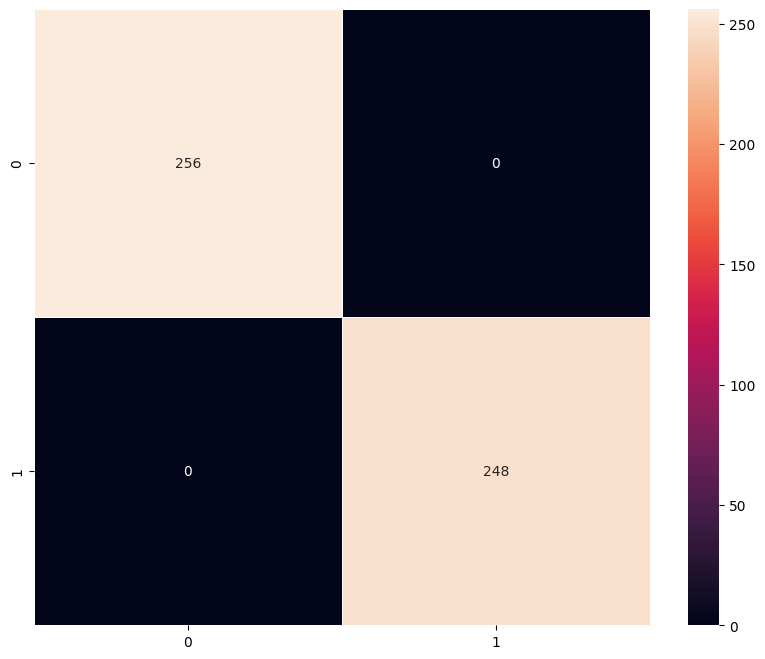

In [76]:
# Plotting confusion matrix of model 4 on train data
model4_train_conf_matrix=plot_confusion_matrix(model_4,X_train_normalized,y_train)
model4_train_conf_matrix

In [81]:
# Performance metrics of model 4 on train data
model4_train_perf=model_performance_classification(model_4,X_train_normalized,y_train)
model4_train_perf

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


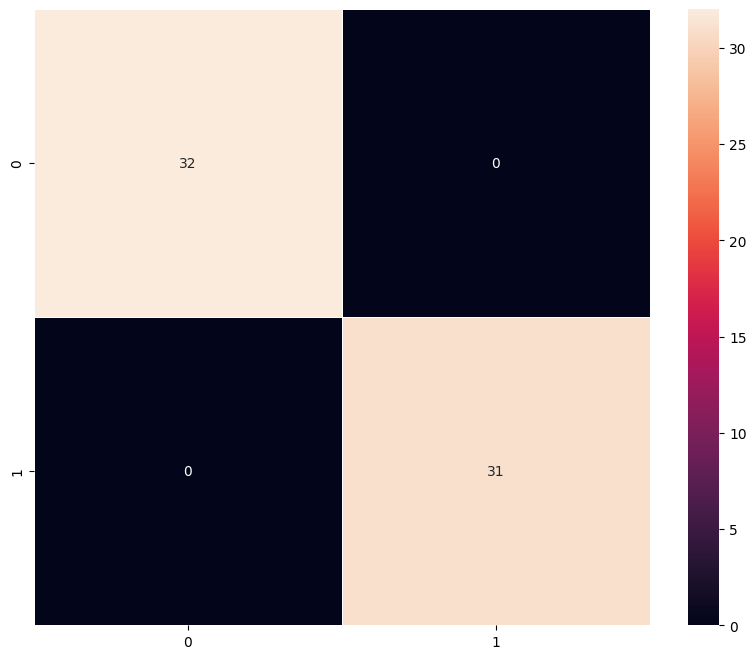

In [77]:
# Plotting confusion matrix of model 4 on validation data
model4_val_conf_matrix=plot_confusion_matrix(model_4,X_val_normalized,y_val)
model4_val_conf_matrix

In [78]:
# Performance metrics of model 4 on validation data
model4_val_perf=model_performance_classification(model_4,X_val_normalized,y_val)
model4_val_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


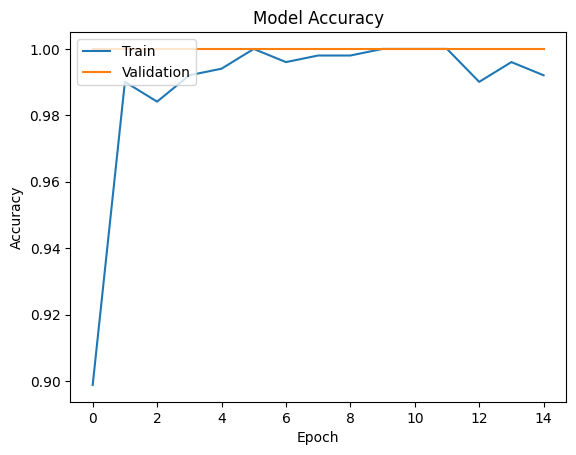

In [79]:
# Plotting train and validation accuracy over epochs
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Model 4 performance
  * Train set
    * Perfect performance with an accuracy of 100%
    * The model successfully detected all images without a helmet (256)
    * The model successfully detected all images with a helmet (248)
  * Validation set
    * Perfect performance with an accuracy of 100%
    * The model successfully detected all images without a helmet (32)
    * The model successfully detected all images with a helmet (31)
  * The model has perfect generalization ability (among unseen data within **this** dataset) since the validation and train metrics are both 100%

  * Important observation:
    * Just like in model 2 and 3, the perfect performance on the train and validation dataset could be a result of the **dataset bias** that I mentioned earlier in the EDA.
    * Since images without a helmet are close-ups with the face dominating the frame and images with a helmet often have workers in a wide scene with differing backgrounds, the model **may not actually be learning helmet detection**. Instead, it's **learning image context** and **scale patterns**.
    * Due to VGG16's excellent feature extraction capabilities, it is easily picking up this dataset bias (especially with the FFNN further reinforcing this bias) and therefore making perfect predictions within this dataset.
    * Further proof of this phenomenon can be interpreted from the line plot depicting the train and validation accuracy over epochs:
      * Data augmentation was applied only to the train data as per best practices. This image augmentation helps combat the dataset bias mentioned earlier.
      * In the line plot, the accuracy of the **validation** data remains 100% over all epochs. The images are **unaltered** which **maintains the dataset bias**, which leads to perfect predictions. This can be seen across the train and validation datasets in models 2 and 3.
      * However, the accuracy of the **train** data in the line plot fluctuates below 100%. This is due to the **data augmentation combating the dataset bias**, preventing the model from being 100% accurate over each epoch.

# **Model Performance Comparison and Final Model Selection**

In [82]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model1_train_perf.T,
        model2_train_perf.T,
        model3_train_perf.T,
        model4_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Simple CNN","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [83]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        model1_val_perf.T,
        model2_val_perf.T,
        model3_val_perf.T,
        model4_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Simple CNN","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [84]:
models_train_comp_df

,Simple CNN,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.853175,1.0,1.0,1.0
Recall,0.853175,1.0,1.0,1.0
Precision,0.886099,1.0,1.0,1.0
F1 Score,0.849572,1.0,1.0,1.0


In [85]:
models_val_comp_df

,Simple CNN,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.793651,1.0,1.0,1.0
Recall,0.793651,1.0,1.0,1.0
Precision,0.853263,1.0,1.0,1.0
F1 Score,0.783697,1.0,1.0,1.0


* Model Performance Comparison:
  * Model 1 (simple CNN) trained on grayscale data had the lowest performance (with an accuracy on validation around 80%)
    * This is likely due to relatively simple CNN architecture with fewer convolution layers. With a few layers, only reltively 'simple' features were extracted (such as vertical and horizontal edges).
  * Model 2 (VGG-16 (Base)), Model 3 (VGG-16 (Base+FFNN)) and Model 4 (VGG-16 (Base+FFNN+Data Aug)) all performed the same with 100% accuracy. These 3 models are trained on the same RGB data.
    * This likely due to the use of transfer learning; using pre-trained weights imbedded into a comprehensive VVG-16 architecture with many convolutional layers structured in a way to successfully extract both 'simple' and 'complex' features.
    * This effective feature extraction in combination with the dataset bias has lead to perfect performance.
    * This leads to perfect generalizability within this dataset.

* Final Model Selection:
  * In the context of this dataset, there is no difference in performance  between Model 2, Model 3 and Model 4.
  * However the final model I will select for testing is Model 4
    * VGG-16 Base: excellent feature extraction.
    * FFNN: not necessary in this case, but generally allows for fine-tuning the pre-trained model to our specific dataset.
    * Data Augmentation: not necessary in this case either, but generally allows for a larger, more diverse and more robust training data, preventing overfitting. It can also mitigate dataset bias to some extent.

## Test Performance

In [89]:
# Performance of test data using Model 4
model4_test_perf=model_performance_classification(model_4,X_test_normalized,y_test)
model4_test_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


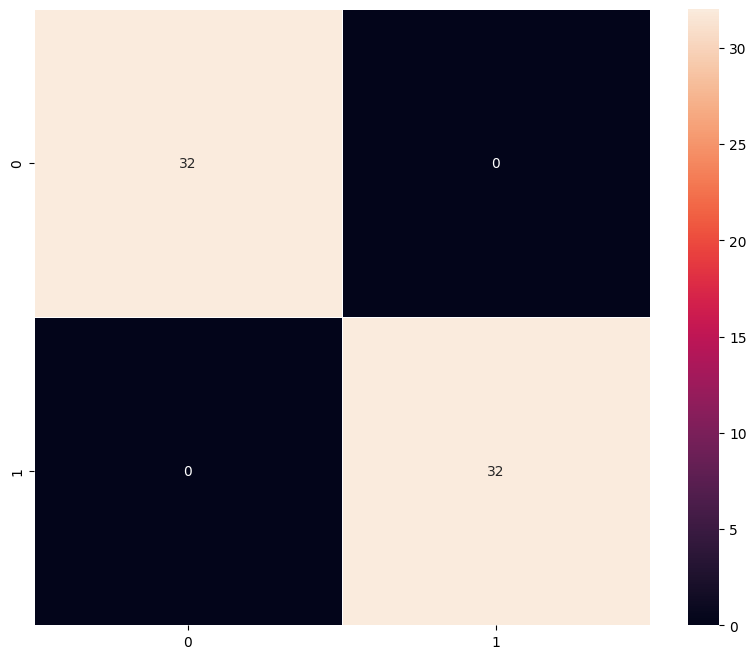

In [90]:
# Confusion matrix of test data using Model 4
model4_test_conf_matrix=plot_confusion_matrix(model_4,X_test_normalized,y_test)
model4_test_conf_matrix

* Model 4 performance on test data
  * As expected, the model has perfect performance with 100% accuracy
  * It was able to successfully detect all images with a helmet and all images without a helmet.
  * It has perfect generalizability within this dataset.

# **Actionable Insights & Recommendations**

* Using **transfer learning** significantly improves model performance
  * Utilizing a pre-trained model such as VGG-16 can help with **successful feature extraction**
  * Combining a pre-trained model with a Feed Forward Neural Network, although not necessary in this case, allows for **fine-tuning** the model on our specific dataset which improves performance
  * Consider using pre-trained models that are trained on data **similar** to the data being used for fine-tuning.
* Utilizing **data augmentation**, also not necessary in this case, allows for a larger, more diverse and more robust training data, **preventing overfitting**. It can also mitigate dataset bias to some extent. This can also improve performance.
* The models are very good at predicting and generalizing **within** this specific dataset.
  * This could be due to the **dataset bias** where images without a helmet are close-ups where the face dominates the frame. Whereas the images without a helmet, the worker is often small in the scene with lots of background.
  * The model may have learnt to distinguish based on **scale and context**, not on the helmet itself, causing a shortcut learning problem.
      * This could lead to **poor generalization of the model with external, real-world data**. For example: if a no-helmet worker is in a distant shot, it may wrongly predict "With Helmet" due to the context.
      * I would recommend the utilization of more **diverse dataset** that is more representative of real-world data. **Balanced feature representation** should be ensured. For example, images without a helmet should have varying context, scaling and background, just like the images with a helmet.
        * This would encourage the model to classify the images based off the existence or absence of a helmet, rather than the context itself.

* Taking this all into account, these CNN models can **successfully automate helmet detection**, thereby improving **safety enforcement**, **ensuring compliance** and **reducing the risk of head injuries**, ultimately fostering a **safer work environment** while **minimizing human error** in safety oversight.

<font size=5 color='blue'>Power Ahead!</font>
___